#### Altair useful posts

# Altair interactiviy between charts

https://towardsdatascience.com/altair-plot-deconstruction-visualizing-the-correlation-structure-of-weather-data-38fb5668c5b1

### Add shapes for mrkers to line charts
alt.Chart(source).mark_line().encode(
    x='date',
    y='price',
    color='symbol',
    shape=alt.Shape('symbol', scale=alt.Scale(range=['cross', 'circle', 'square', 'triangle-right', 'diamond']))
)

# Regression

*Supervised* machine learning techniques involve training a model to operate on a set of *features* and predict a *label* using a dataset that includes some already-known label values. The training process *fits* the features to the known labels to define a general function that can be applied to new features for which the labels are unknown, and predict them. You can think of this function like this, in which ***y*** represents the label we want to predict and ***x*** represents the features the model uses to predict it.

$$y = f(x)$$

In most cases, *x* is actually a *vector* that consists of multiple feature values, so to be a little more precise, the function could be expressed like this:

$$y = f([x_1, x_2, x_3, ...])$$

The goal of training the model is to find a function that performs some kind of calculation to the *x* values that produces the result *y*. We do this by applying a machine learning *algorithm* that tries to fit the *x* values to a calculation that produces *y* reasonably accurately for all of the cases in the training dataset.

There are lots of machine learning algorithms for supervised learning, and they can be broadly divided into two types:

- **_Regression_ algorithms**: Algorithms that predict a *y* value that is a numeric value, such as the price of a house or the number of sales transactions.
- **_Classification_ algorithms**: Algorithms that predict to which category, or *class*, an observation belongs. The *y* value in a classification model is a vector of probability values between 0 and 1, one for each class, indicating the probability of the observation belonging to each class.

In this notebook, we'll focus on *regression*, using an example based on a real study in which data for a bicycle sharing scheme was collected and used to predict the number of rentals based on seasonality and weather conditions. We'll use a simplified version of the dataset from that study.

> **Citation**: The data used in this exercise is derived from [Capital Bikeshare](https://www.capitalbikeshare.com/system-data) and is used in accordance with the published [license agreement](https://www.capitalbikeshare.com/data-license-agreement).

## Explore the Data

The first step in any machine learning project is to explore the data that you will use to train a model. The goal of this exploration is to try to understand the relationships between its attributes; in particular, any apparent correlation between the *features* and the *label* your model will try to predict. This may require some work to detect and fix issues in the data (such as dealing with missing values, errors, or outlier values), deriving new feature columns by transforming or combining existing features (a process known as *feature engineering*), *normalizing* numeric features (values you can measure or count) so they're on a similar scale, and *encoding* categorical features (values that represent discrete categories) as numeric indicators.

Let's start by loading the bicycle sharing data as a **Pandas** DataFrame and viewing the first few rows.

In [1]:
import pandas as pd

# load the training dataset
bike_data = pd.read_csv('data/daily-bike-share.csv')
bike_data.head()

instant    dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  1/1/2011       1   0     1        0        6           0   
1        2  1/2/2011       1   0     1        0        0           0   
2        3  1/3/2011       1   0     1        0        1           1   
3        4  1/4/2011       1   0     1        0        2           1   
4        5  1/5/2011       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  rentals  
0           2  0.344167  0.363625  0.805833   0.160446      331  
1           2  0.363478  0.353739  0.696087   0.248539      131  
2           1  0.196364  0.189405  0.437273   0.248309      120  
3           1  0.200000  0.212122  0.590435   0.160296      108  
4           1  0.226957  0.229270  0.436957   0.186900       82

In [2]:
for col in bike_data[['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit' ]]:
    print (f"Value counts for field {col} is\n {bike_data[col].value_counts()}")

Value counts for field yr is
 1    366
0    365
Name: yr, dtype: int64
Value counts for field mnth is
 12    62
10    62
8     62
7     62
5     62
3     62
1     62
11    60
9     60
6     60
4     60
2     57
Name: mnth, dtype: int64
Value counts for field holiday is
 0    710
1     21
Name: holiday, dtype: int64
Value counts for field weekday is
 6    105
1    105
0    105
5    104
4    104
3    104
2    104
Name: weekday, dtype: int64
Value counts for field workingday is
 1    500
0    231
Name: workingday, dtype: int64
Value counts for field weathersit is
 1    463
2    247
3     21
Name: weathersit, dtype: int64


In [3]:
bike_data.select_dtypes(["float"])

temp     atemp       hum  windspeed
0    0.344167  0.363625  0.805833   0.160446
1    0.363478  0.353739  0.696087   0.248539
2    0.196364  0.189405  0.437273   0.248309
3    0.200000  0.212122  0.590435   0.160296
4    0.226957  0.229270  0.436957   0.186900
..        ...       ...       ...        ...
726  0.254167  0.226642  0.652917   0.350133
727  0.253333  0.255046  0.590000   0.155471
728  0.253333  0.242400  0.752917   0.124383
729  0.255833  0.231700  0.483333   0.350754
730  0.215833  0.223487  0.577500   0.154846

[731 rows x 4 columns]

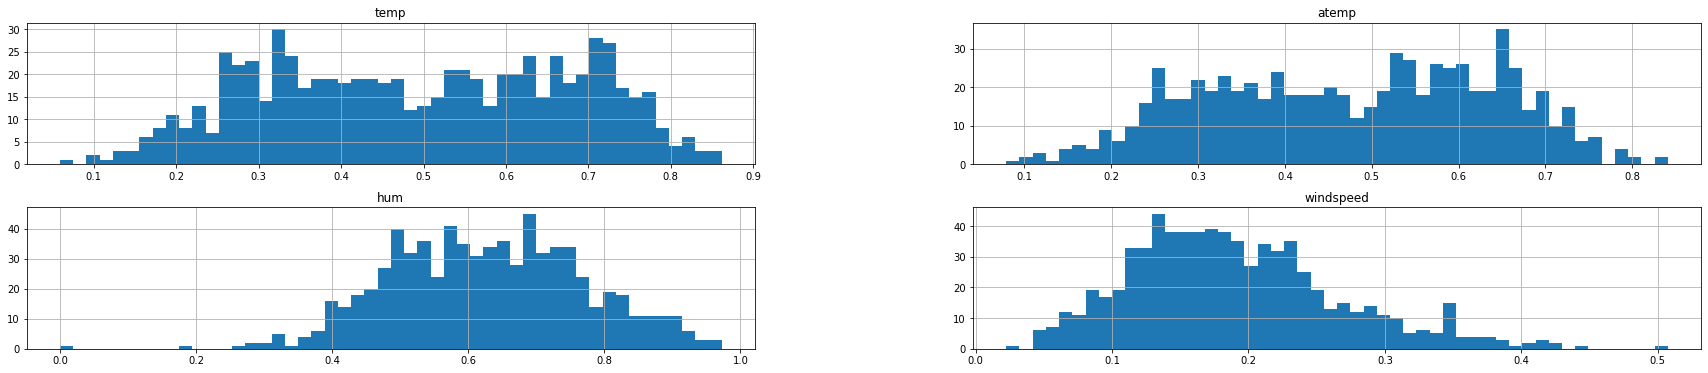

In [4]:
import matplotlib.pyplot as plt
df_in = bike_data.select_dtypes(['float'])

fig, axes = plt.subplots(len(df_in.columns)//2, 2, figsize=(30, 6 ))

i = 0
for triaxis in axes:
    for axis in triaxis:
        df_in.hist(column = df_in.columns[i], bins = 50, ax=axis)
        i = i+1

The data consists of the following columns:

- **instant**: A unique row identifier
- **dteday**: The date on which the data was observed - in this case, the data was collected daily; so there's one row per date.
- **season**: A numerically encoded value indicating the season (1:spring, 2:summer, 3:fall, 4:winter)
- **yr**: The year of the study in which the observation was made (the study took place over two years - year 0 represents 2011, and year 1 represents 2012)
- **mnth**: The calendar month in which the observation was made (1:January ... 12:December)
- **holiday**: A binary value indicating whether or not the observation was made on a public holiday)
- **weekday**: The day of the week on which the observation was made (0:Sunday ... 6:Saturday)
- **workingday**: A binary value indicating whether or not the day is a working day (not a weekend or holiday)
- **weathersit**: A categorical value indicating the weather situation (1:clear, 2:mist/cloud, 3:light rain/snow, 4:heavy rain/hail/snow/fog)
- **temp**: The temperature in celsius (normalized)
- **atemp**: The apparent ("feels-like") temperature in celsius (normalized)
- **hum**: The humidity level (normalized)
- **windspeed**: The windspeed (normalized)
- **rentals**: The number of bicycle rentals recorded.

In this dataset, **rentals** represents the label (the *y* value) our model must be trained to predict. The other columns are potential features (*x* values).

As mentioned previously, you can perform some *feature engineering* to combine or derive new features. For example, let's add a new column named **day** to the dataframe by extracting the day component from the existing **dteday** column. The new column represents the day of the month from 1 to 31.

In [5]:
bike_data['day'] = pd.DatetimeIndex(bike_data['dteday']).day
bike_data.head(5)

instant    dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  1/1/2011       1   0     1        0        6           0   
1        2  1/2/2011       1   0     1        0        0           0   
2        3  1/3/2011       1   0     1        0        1           1   
3        4  1/4/2011       1   0     1        0        2           1   
4        5  1/5/2011       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  rentals  day  
0           2  0.344167  0.363625  0.805833   0.160446      331    1  
1           2  0.363478  0.353739  0.696087   0.248539      131    2  
2           1  0.196364  0.189405  0.437273   0.248309      120    3  
3           1  0.200000  0.212122  0.590435   0.160296      108    4  
4           1  0.226957  0.229270  0.436957   0.186900       82    5

OK, let's start our analysis of the data by examining a few key descriptive statistics. We can use the dataframe's **describe** method to generate these for the numeric features as well as the **rentals** label column.

In [6]:
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
bike_data[numeric_features + ['rentals']].describe()

temp       atemp         hum   windspeed      rentals
count  731.000000  731.000000  731.000000  731.000000   731.000000
mean     0.495385    0.474354    0.627894    0.190486   848.176471
std      0.183051    0.162961    0.142429    0.077498   686.622488
min      0.059130    0.079070    0.000000    0.022392     2.000000
25%      0.337083    0.337842    0.520000    0.134950   315.500000
50%      0.498333    0.486733    0.626667    0.180975   713.000000
75%      0.655417    0.608602    0.730209    0.233214  1096.000000
max      0.861667    0.840896    0.972500    0.507463  3410.000000

The statistics reveal some information about the distribution of the data in each of the numeric fields, including the number of observations (there are 731 records), the mean, standard deviation, minimum and maximum values, and the quartile values (the threshold values for 25%, 50% - which is also the median, and 75% of the data). From this, we can see that the mean number of daily rentals is around 848; but there's a comparatively large standard deviation, indicating a lot of variance in the number of rentals per day.

We might get a clearer idea of the distribution of rentals values by visualizing the data. Common plot types for visualizing numeric data distributions are *histograms* and *box plots*, so let's use Python's **matplotlib** library to create one of each of these for the **rentals** column.

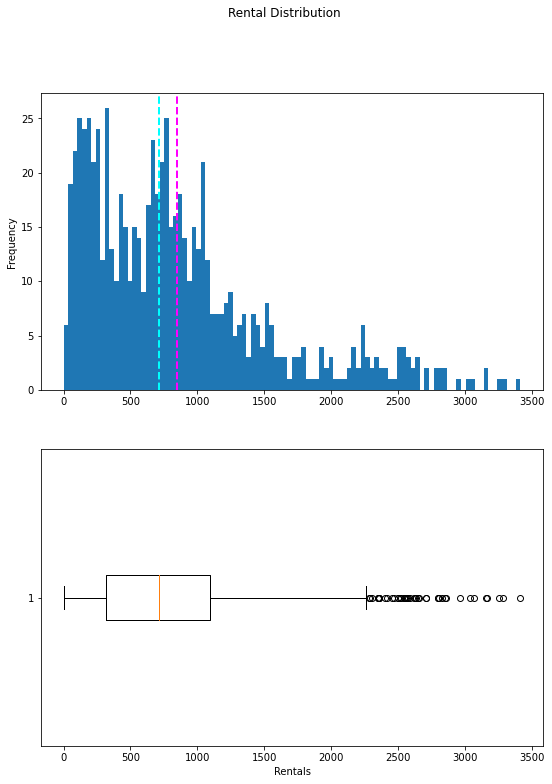

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# This ensures plots are displayed inline in the Jupyter notebook
%matplotlib inline

# Get the label column
label = bike_data['rentals']


# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequency')

# Add lines for the mean, median, and mode
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('Rentals')

# Add a title to the Figure
fig.suptitle('Rental Distribution')

# Show the figure
fig.show()


In [8]:
import altair as alt

def plotDistributionForColumn(df, colName):

    """
        This function plots a histogram for a column of the df  dataframe 
        At the botton of the histogram, it plots a boxplot
    """
    source = df[[colName]]

    base = alt.Chart(source, title=colName)

    B = base.mark_bar(color='green').encode(
        alt.X(f"{colName}:Q", bin=alt.Bin(maxbins=100)),
        y='count()',
    )

    mean_rule = alt.Chart(source).mark_rule(color='red').encode(
        x=f'mean({colName}):Q'
    )

    median_rule = alt.Chart(source).mark_rule(color='orange').encode(
        x=f'median({colName}):Q'
    )

    box_plot = base.mark_boxplot().encode(
        x=f'{colName}:Q',

    )

    return B + mean_rule + median_rule & box_plot
    


In [9]:
from IPython.display import display
for col in numeric_features + ['rentals']:
    chart = plotDistributionForColumn(bike_data, col)
    display(chart)


alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

In [10]:
plotDistributionForColumn(bike_data, 'atemp')

alt.VConcatChart(...)

The plots show that the number of daily rentals ranges from 0 to just over 3,400. However, the mean (and median) number of daily rentals is closer to the low end of that range, with most of the data between 0 and around 2,200 rentals. The few values above this are shown in the box plot as small circles, indicating that they are *outliers* - in other words, unusually high or low values beyond the typical range of most of the data.

We can do the same kind of visual exploration of the numeric features. Let's create a histogram for each of these.

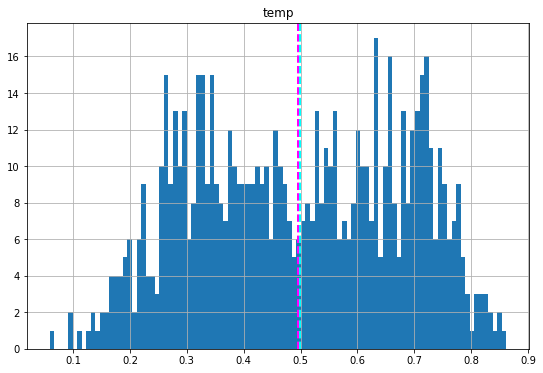

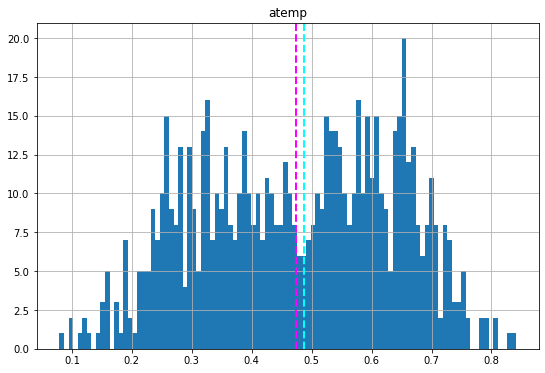

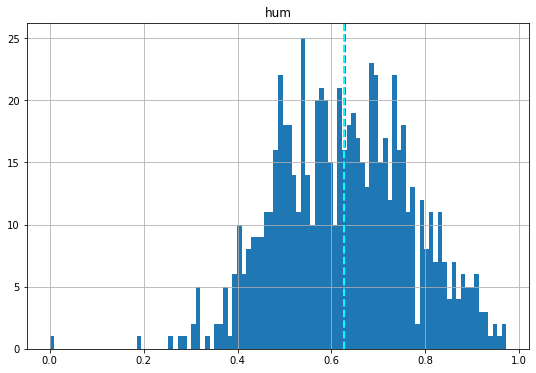

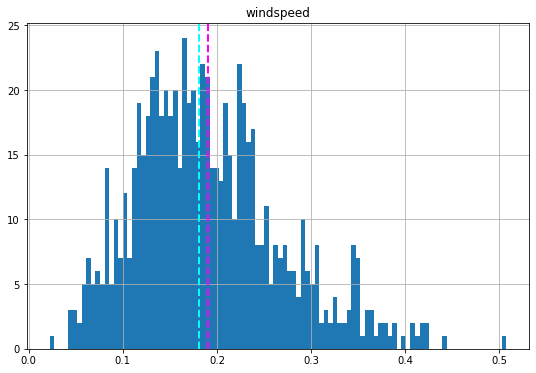

In [11]:
# Plot a histogram for each numeric feature
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = bike_data[col]
    feature.hist(bins=100, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
    ax.set_title(col)
plt.show()

The numeric features seem to be more *normally* distributed, with the mean and median nearer the middle of the range of values, coinciding with where the most commonly occurring values are.

> **Note**: The distributions are not truly *normal* in the statistical sense, which would result in a smooth, symmetric "bell-curve" histogram with the mean and mode (the most common value) in the center; but they do generally indicate that most of the observations have a value somewhere near the middle.

We've explored the distribution of the numeric values in the dataset, but what about the categorical features? These aren't continuous numbers on a scale, so we can't use histograms; but we can plot a bar chart showing the count of each discrete value for each category.

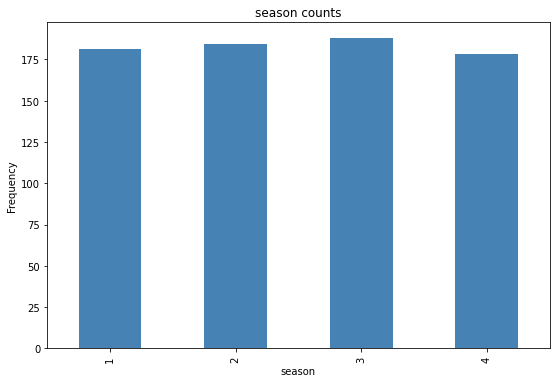

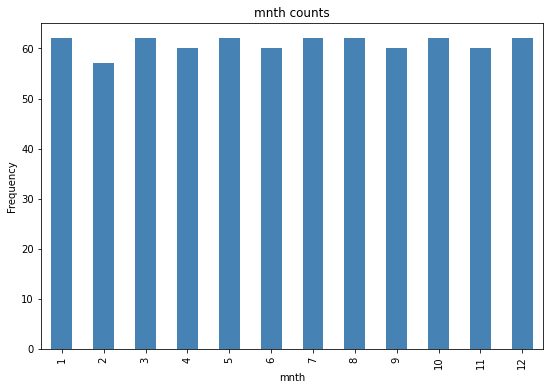

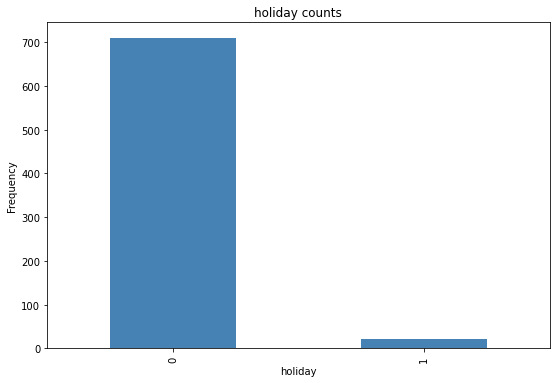

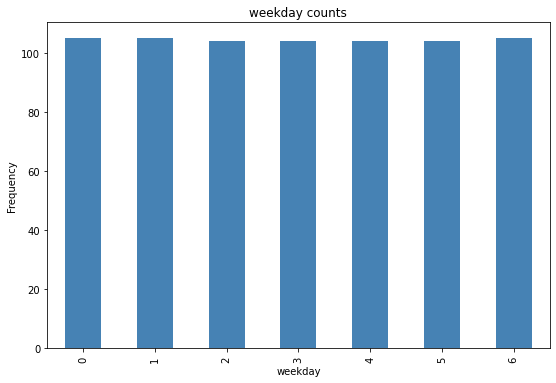

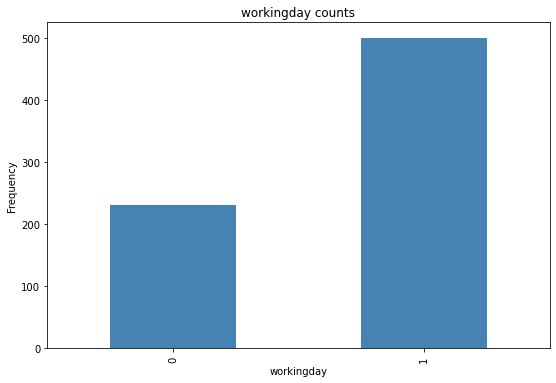

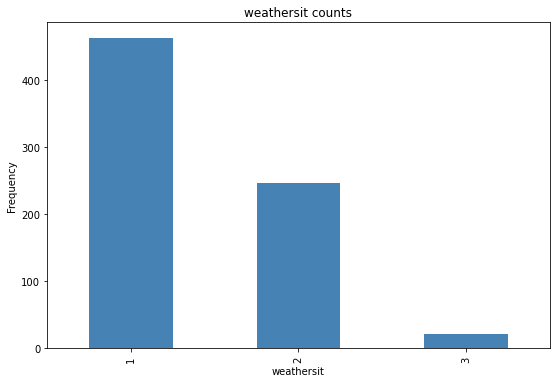

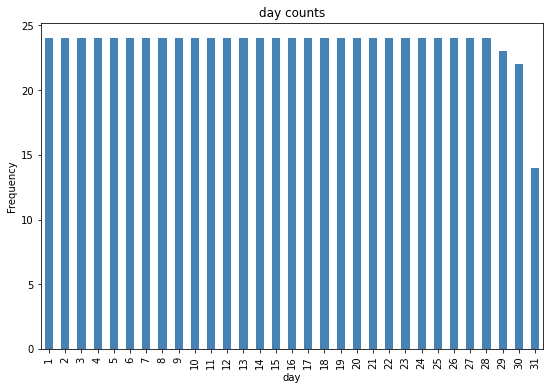

In [12]:
import numpy as np

# plot a bar plot for each categorical feature count
categorical_features = ['season','mnth','holiday','weekday','workingday','weathersit', 'day']

for col in categorical_features:
    counts = bike_data[col].value_counts().sort_index()
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    counts.plot.bar(ax = ax, color='steelblue')
    ax.set_title(col + ' counts')
    ax.set_xlabel(col) 
    ax.set_ylabel("Frequency")
plt.show()


In [13]:

def plotCategoricalfeatures(df, colName):

    """
        This function plots a br graph for  a column of the df  dataframe. 
        The type of the column is categorical 
        At the botton of the histogram, it plots a boxplot
    """
    source = df[[colName]]

    base = alt.Chart(source, title=colName)

    B = base.mark_bar(color='#20b2aa').encode(
        alt.X(f"{colName}:N"),
        y='count()',
    )

    return B 

In [14]:
  # Call the function in a cell using IPython display to chart all the columns at the same time
    from IPython.display import display
    
    for col in categorical_features:
      chart = plotCategoricalfeatures(bike_data, col)
      display(chart)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

Many of the categorical features show a more or less *uniform* distribution (meaning there's roughly the same number of rows for each category). Exceptions to this include:

- **holiday**: There are many fewer days that are holidays than days that aren't.
- **workingday**: There are more working days than non-working days.
- **weathersit**: Most days are category *1* (clear), with category *2* (mist and cloud) the next most common. There are comparatively few category *3* (light rain or snow) days, and no category *4* (heavy rain, hail, or fog) days at all.

Now that we know something about the distribution of the data in our columns, we can start to look for relationships between the features and the **rentals** label we want to be able to predict.

For the numeric features, we can create scatter plots that show the intersection of feature and label values. We can also calculate the *correlation* statistic to quantify the apparent relationship.. 

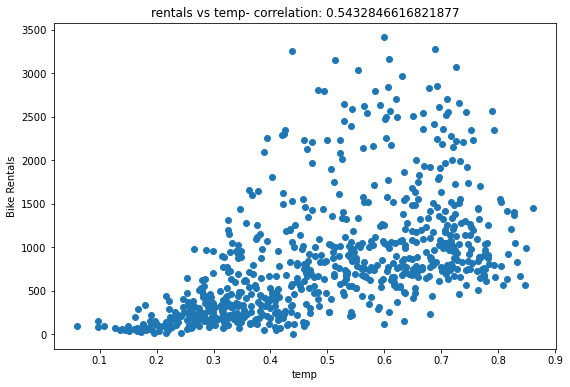

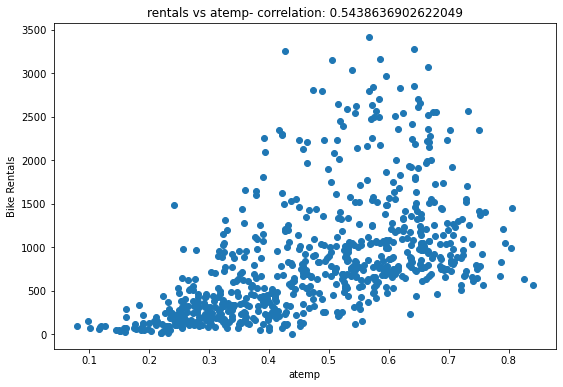

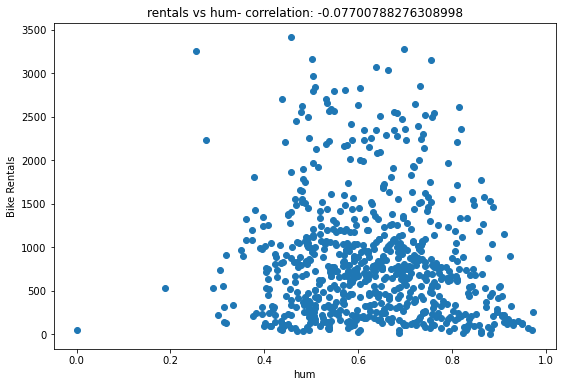

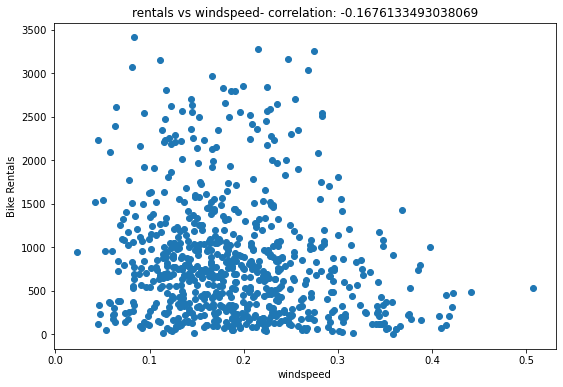

In [15]:
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = bike_data[col]
    label = bike_data['rentals']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Bike Rentals')
    ax.set_title('rentals vs ' + col + '- correlation: ' + str(correlation))
plt.show()


The results aren't conclusive, but if you look closely at the scatter plots for **temp** and **atemp**, you can see a vague diagonal trend showing that higher rental counts tend to coincide with higher temperatures; and a correlation value of just over 0.5 for both of these features supports this observation. Conversely, the plots for **hum** and **windspeed** show a slightly negative correlation, indicating that there are fewer rentals on days with high humidity or windspeed.

Now let's compare the categorical features to the label. We'll do this by creating box plots that show the distribution of rental counts for each category.

In [16]:
import altair as alt


def createCorrelationScatters(df, colName, targetName):
    """
        This function created a scatter chart and a line that is a regression line between the two numerical columns passed to it
        It prints out the correlation values as well
    """


    corr = df[targetName].corr(df[colName])
    source = df

    base = alt.Chart(source)

    chart = base.mark_circle().encode(
        alt.X(f"{colName}:Q"),
        alt.Y(f"{targetName}:Q"),
        color=alt.value("orange")
    ).properties(
        width=300,
        height=150
    )
    text = base.mark_text(
                            align="left", baseline="top"
                        ).encode(
                        x=alt.value(5),  # pixels from left
                        y=alt.value(5),  # pixels from top
                        text=alt.value(f"corr: {corr:.3f}"),
                        )

    return chart + text+ chart.transform_regression(colName, targetName).mark_line(color='darkblue').encode(color=alt.value('blue'))

In [17]:
targetName = 'rentals'
for colName in numeric_features:
   chart  = createCorrelationScatters(bike_data, colName, targetName)
   display(chart)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

In [18]:
### Create box plots of the target - facet by values of the categorical values

def createBarsForTargetPerCategory(df, targetName, catColName ):
    source = bike_data
    base = alt.Chart(source)

    box_plot = base.mark_boxplot().encode(
            y=f'{targetName}:Q',

        ).facet(
            column=f'{catColName}:N'
        )

    return box_plot    

    targetName = 'rentals'
for catColName in categorical_features:
   chart  = createBarsForTargetPerCategory(bike_data, targetName, catColName)
   display(chart)



alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

In [19]:
targetName = 'rentals'
for catColName in categorical_features:
   chart  = createBarsForTargetPerCategory(bike_data, targetName, catColName)
   display(chart)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

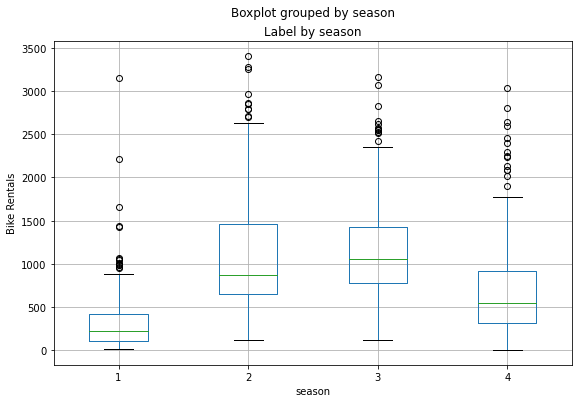

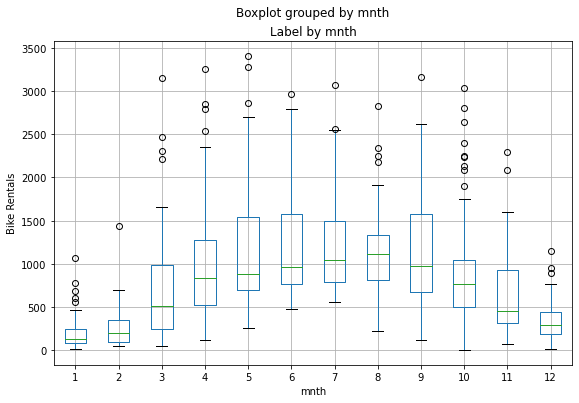

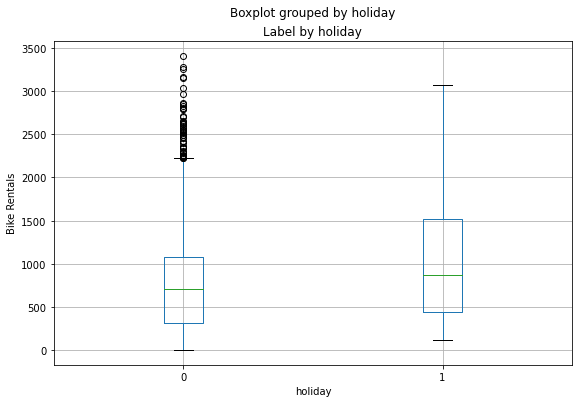

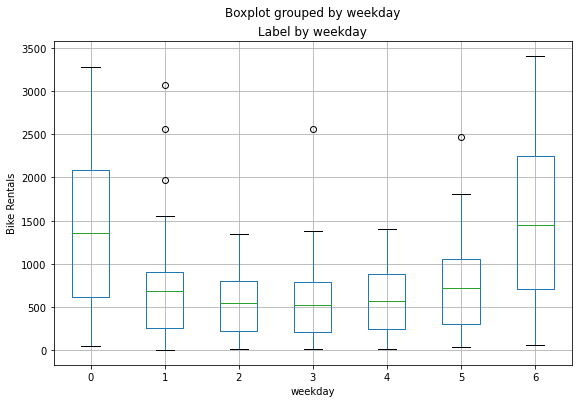

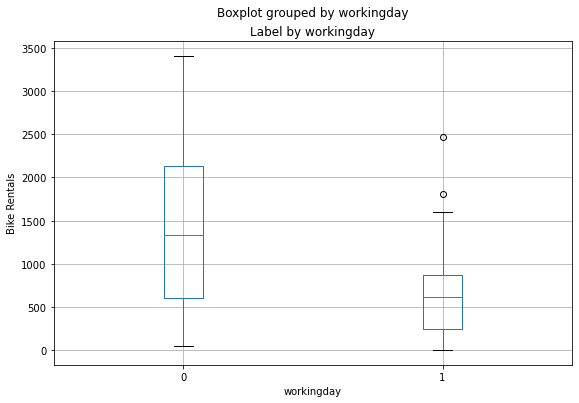

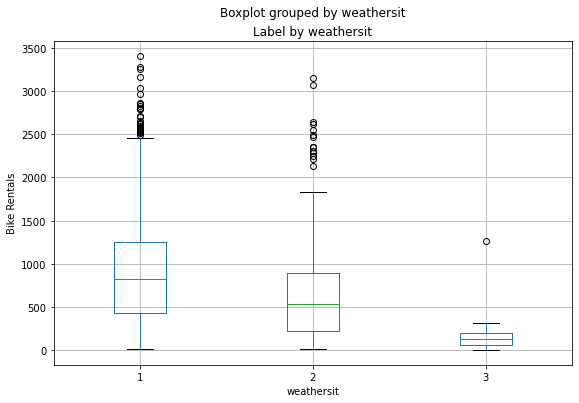

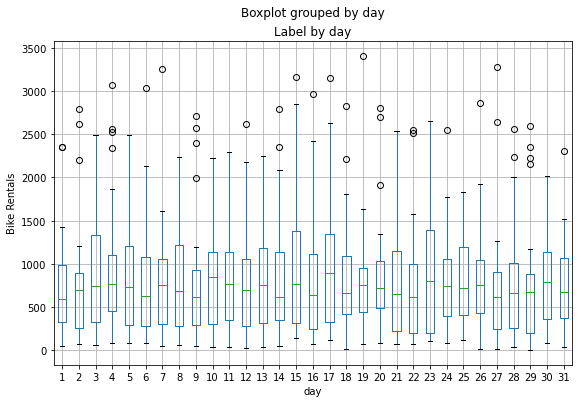

In [20]:
# plot a boxplot for the label by each categorical feature
for col in categorical_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    bike_data.boxplot(column = 'rentals', by = col, ax = ax)
    ax.set_title('Label by ' + col)
    ax.set_ylabel("Bike Rentals")
plt.show()

The plots show some variance in the relationship between some category values and rentals. For example, there's a clear difference in the distribution of rentals on weekends (**weekday** 0 or 6) and those during the working week (**weekday** 1 to 5). Similarly, there are notable differences for **holiday** and **workingday** categories. There's a noticeable trend that shows different rental distributions in summer and fall months compared to spring and winter months. The **weathersit** category also seems to make a difference in rental distribution. The **day** feature we created for the day of the month shows little variation, indicating that it's probably not predictive of the number of rentals.

## Train a Regression Model

Now that we've explored the data, it's time to use it to train a regression model that uses the features we've identified as potentially predictive to predict the **rentals** label.  The first thing we need to do is to separate the features we want to use to train the model from the label we want it to predict.

In [21]:
# Separate features and labels
X_cols = ['season','mnth', 'holiday','weekday','workingday','weathersit','temp', 'atemp', 'hum', 'windspeed']
X, y = bike_data[['season','mnth', 'holiday','weekday','workingday','weathersit','temp', 'atemp', 'hum', 'windspeed']].values, bike_data['rentals'].values
print('Features:',X[:10], '\nLabels:', y[:10], sep='\n')

Features:
[[1.        1.        0.        6.        0.        2.        0.344167
  0.363625  0.805833  0.160446 ]
 [1.        1.        0.        0.        0.        2.        0.363478
  0.353739  0.696087  0.248539 ]
 [1.        1.        0.        1.        1.        1.        0.196364
  0.189405  0.437273  0.248309 ]
 [1.        1.        0.        2.        1.        1.        0.2
  0.212122  0.590435  0.160296 ]
 [1.        1.        0.        3.        1.        1.        0.226957
  0.22927   0.436957  0.1869   ]
 [1.        1.        0.        4.        1.        1.        0.204348
  0.233209  0.518261  0.0895652]
 [1.        1.        0.        5.        1.        2.        0.196522
  0.208839  0.498696  0.168726 ]
 [1.        1.        0.        6.        0.        2.        0.165
  0.162254  0.535833  0.266804 ]
 [1.        1.        0.        0.        0.        1.        0.138333
  0.116175  0.434167  0.36195  ]
 [1.        1.        0.        1.        1.        1.        

After separating the dataset, we now have numpy arrays named **X** containing the features, and **y** containing the labels.

We *could* train a model using all of the data; but it's common practice in supervised learning to split the data into two subsets; a (typically larger) set with which to train the model, and a smaller "hold-back" set with which to validate the trained model. This enables us to evaluate how well the model performs when used with the validation dataset by comparing the predicted labels to the known labels. It's important to split the data *randomly* (rather than say, taking the first 70% of the data for training and keeping the rest for validation). This helps ensure that the two subsets of data are statistically comparable (so we validate the model with data that has a similar statistical distribution to the data on which it was trained).

To randomly split the data, we'll use the **train_test_split** function in the **scikit-learn** library. This library is one of the most widely used machine learning packages for Python.

In [22]:
type(X)

numpy.ndarray

In [23]:
from sklearn.model_selection import train_test_split

# Split data 70%-30% into training set and test set  
#Note : set a random state so that every run provides the same result. especially important if someone else is working on it and wants to reproduce yours
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 511 rows
Test Set: 220 rows


Now we have the following four datasets:

- **X_train**: The feature values we'll use to train the model
- **y_train**: The corresponding labels we'll use to train the model
- **X_test**: The feature values we'll use to validate the model
- **y_test**: The corresponding labels we'll use to validate the model

Now we're ready to train a model by fitting a suitable regression algorithm to the training data. We'll use a *linear regression* algorithm, a common starting point for regression that works by trying to find a linear relationship between the *X* values and the *y* label. The resulting model is a function that conceptually defines a line where every possible X and y value combination intersect.

In Scikit-Learn, training algorithms are encapsulated in *estimators*, and in this case we'll use the **LinearRegression** estimator to train a linear regression model.

In [24]:
# Train the model
from sklearn.linear_model import LinearRegression

# Fit a linear regression model on the training set
model = LinearRegression().fit(X_train, y_train)
print (model)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


### Evaluate the Trained Model

Now that we've trained the model, we can use it to predict rental counts for the features we held back in our validation dataset. Then we can compare these predictions to the actual label values to evaluate how well (or not!) the model is working.

In [25]:
import numpy as np

predictions = model.predict(X_test)
np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions)[:10])
print('Actual labels   : ' ,y_test[:10])

Predicted labels:  [1896. 1184. 1007.  -28.  314.  385.  475.  590. 1476.  -22.]
Actual labels   :  [2418  754  222   47  244  145  240  555 3252   38]


Comparing each prediction with its corresponding "ground truth" actual value isn't a very efficient way to determine how well the model is predicting. Let's see if we can get a better indication by visualizing a scatter plot that compares the predictions to the actual labels. We'll also overlay a trend line to get a general sense for how well the predicted labels align with the true labels.

In [26]:
predictions = model.predict(X_test)
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)

In [27]:
p

poly1d([  0.58695162, 374.20560471])

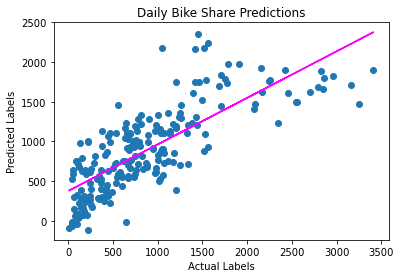

In [28]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

There's a definite diagonal trend, and the intersections of the predicted and actual values are generally following the path of the trend line; but there's a fair amount of difference between the ideal function represented by the line and the results. This variance represents the *residuals* of the model - in other words, the difference between the label predicted when the model applies the coefficients it learned during training to the validation data, and the actual value of the validation label. These residuals when evaluated from the validation data indicate the expected level of *error* when the model is used with new data for which the label is unknown.

You can quantify the residuals by calculating a number of commonly used evaluation metrics. We'll focus on the following three:

- **Mean Square Error (MSE)**: The mean of the squared differences between predicted and actual values. This yields a relative metric in which the smaller the value, the better the fit of the model
- **Root Mean Square Error (RMSE)**: The square root of the MSE. This yields an absolute metric in the same unit as the label (in this case, numbers of rentals). The smaller the value, the better the model (in a simplistic sense, it represents the average number of rentals by which the predictions are wrong!)
- **Coefficient of Determination (usually known as *R-squared* or R<sup>2</sup>)**: A relative metric in which the higher the value, the better the fit of the model. In essence, this metric represents how much of the variance between predicted and actual label values the model is able to explain.

> **Note**: You can find out more about these and other metrics for evaluating regression models in the [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

Let's use Scikit-Learn to calculate these metrics for our model, based on the predictions it generated for the validation data.

In [29]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R2:", r2)

MSE: 201972.55947035592
RMSE: 449.4135728595165
R2: 0.6040454736919191


So now we've quantified the ability of our model to predict the number of rentals. It definitely has *some* predictive power, but we can probably do better!

## Experiment with Algorithms

The linear regression algorithm we used to train the model has some predictive capability, but there are many kinds of regression algorithm we could try, including:

- **Linear algorithms**: Not just the Linear Regression algorithm we used above (which is technically an *Ordinary Least Squares* algorithm), but other variants such as *Lasso* and *Ridge*.
- **Tree-based algorithms**: Algorithms that build a decision tree to reach a prediction.
- **Ensemble algorithms**: Algorithms that combine the outputs of multiple base algorithms to improve generalizability.

> **Note**: For a full list of Scikit-Learn estimators that encapsulate algorithms for supervised machine learning, see the [Scikit-Learn documentation](https://scikit-learn.org/stable/supervised_learning.html). There are many algorithms to choose from, but for most real-world scenarios, the [Scikit-Learn estimator cheat sheet](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) can help you find a suitable starting point. 

### Try Another Linear Algorithm

Let's try training our regression model by using a **Lasso** algorithm. We can do this by just changing the estimator in the training code.

In [30]:
data = {'y_true':y_test, 'y_pred':predictions}
df = pd.DataFrame(data=data)

# Evaluate the model using the test data
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)


base = alt.Chart(df,   title = 'Daily Bike Share Predictions')

s = base.mark_circle(
    ).encode(
        x = alt.X('y_true:Q',title = 'Actual Labels'),
        y = alt.Y('y_pred:Q', title = 'Predicted Labels'),
        color = alt.value('red')
      
    )

# create a linear relation (polyfit with degree 1) betwen true and predicted values
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)

reg_line = pd.DataFrame({'y_true':y_test, 'y_eval':p(y_test)})

l = alt.Chart(reg_line).mark_line(  
    ).encode(
        x = 'y_true:Q',
        y = 'y_eval:Q'
    )

text = base.mark_text(
                        align="left", baseline="top"
                        ).encode(
                        x=alt.value(5),  # pixels from left
                        y=alt.value(5),  # pixels from top
                        text=alt.value(f"corr: {mse:.3f}   rmse: {rmse:0.3f}   r2: {r2:0.3f}  "),
                        )

s + l + text

alt.LayerChart(...)

In [31]:
reg_line

y_true       y_eval
0      2418  1793.454610
1       754   816.767123
2       222   504.508863
3        47   401.792331
4       244   517.421799
..      ...          ...
215     269   532.095589
216    1383  1185.959688
217     318   560.856218
218     644   752.202445
219     949   931.222687

[220 rows x 2 columns]

In [32]:
# Train the model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Fit a linear regression model on the training set
model = LinearRegression().fit(X_train, y_train)
print (model)

predictions = model.predict(X_test)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


In [33]:
model = LinearRegression().fit(X_train, y_train)
str(model)

'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)'

In [34]:
str(model).split(',')

['LinearRegression(copy_X=True',
 ' fit_intercept=True',
 ' n_jobs=None',
 ' normalize=False)']

In [35]:
def compareTrueAndPredictedLabels(y_true, y_pred, chart_title, degree = 1):
    """
        This function plots a graph (linear - degree 1) that shows the correlation between the true and predicted values of a continuous variable
        Note that -
        R² gives us a measure of how well the actual outcomes are replicated by the model or the regression line. This is based on the total variation of prediction explained by the model.
    """

    data = {'y_true':y_test, 'y_pred':y_pred}
    df = pd.DataFrame(data=data)

    # Evaluate the model using the test data
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    FIG_WIDTH = 300
    FIG_HEIGHT = 200

    base = alt.Chart(
                    df,   title = chart_title
                    ).properties(
                        height = FIG_HEIGHT,
                        width = FIG_WIDTH
                    )

    s = base.mark_circle(
        ).encode(
            x = alt.X('y_true:Q',title = 'Actual Labels'),
            y = alt.Y('y_pred:Q', title = 'Predicted Labels'),
            color = alt.value('red')
        
        )

    # create a linear relation (polyfit with degree 1) betwen true and predicted values
    z = np.polyfit(y_test, y_pred, 1)
    p = np.poly1d(z)

    reg_line = pd.DataFrame({'y_true':y_test, 'y_eval':p(y_test)})

    l = alt.Chart(reg_line).mark_line(  
        ).encode(
            x = 'y_true:Q',
            y = 'y_eval:Q'
        )

    text = base.mark_text(
                            align="right", baseline="bottom", lineBreak='\n'
                            ).encode(
                            x=alt.value(FIG_WIDTH -100),  # pixels from left
                            y=alt.value(FIG_HEIGHT-30),  # pixels from top
                            text=alt.value(f"corr: {mse:.3f}\n   rmse: {rmse:0.3f}\n   r2: {r2:0.3f}\n  "),
                            
                            )

    return s + l + text
    



    

In [36]:
compareTrueAndPredictedLabels(y_test, predictions, str(model).split(','))

alt.LayerChart(...)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) 

MSE: 201155.70593338404
RMSE: 448.5038527519959
R2: 0.6056468637824488


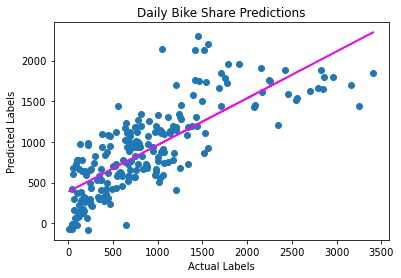

In [37]:
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Fit a lasso model on the training set
model = Lasso(alpha=1).fit(X_train, y_train)
print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

### Try a Decision Tree Algorithm

As an alternative to a linear model, there's a category of algorithms for machine learning that uses a tree-based approach in which the features in the dataset are examined in a series of evaluations, each of which results in a *branch* in a *decision tree* based on the feature value. At the end of each series of branches are leaf-nodes with the predicted label value based on the feature values.

It's easiest to see how this works with an example. Let's train a Decision Tree regression model using the bike rental data. After training the model, the code below will print the model definition and a text representation of the tree it uses to predict label values.

In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import export_text

# Train the model
model = DecisionTreeRegressor().fit(X_train, y_train)
print (model, "\n")

# Visualize the model tree
tree = export_text(model)
print(tree)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best') 

|--- feature_6 <= 0.45
|   |--- feature_4 <= 0.50
|   |   |--- feature_7 <= 0.32
|   |   |   |--- feature_8 <= 0.41
|   |   |   |   |--- feature_1 <= 2.50
|   |   |   |   |   |--- feature_3 <= 3.00
|   |   |   |   |   |   |--- feature_6 <= 0.28
|   |   |   |   |   |   |   |--- value: [515.00]
|   |   |   |   |   |   |--- feature_6 >  0.28
|   |   |   |   |   |   |   |--- value: [558.00]
|   |   |   |   |   |--- feature_3 >  3.00
|   |   |   |   |   |   |--- value: [317.00]
|   |   |   |   |--- feature_1 >  2.50
|   |   |   |   |   |--- feature_8 <= 0.40
|   |   |   |   |   |   |--- feature_

So now we have a tree-based model; but is it any good? Let's evaluate it with the test data.

MSE: 251982.22272727272
RMSE: 501.97830902069137
R2: 0.5060046676653684


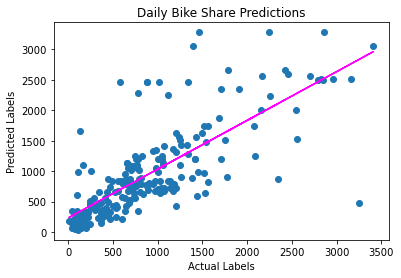

In [39]:
# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

The tree-based model doesn't seem to have improved over the linear model, so what else could we try?

### Try an Ensemble Algorithm

Ensemble algorithms work by combining multiple base estimators to produce an optimal model, either by applying an aggregate function to a collection of base models (sometimes referred to a *bagging*) or by building a sequence of models that build on one another to improve predictive performance (referred to as *boosting*).

For example, let's try a Random Forest model, which applies an averaging function to multiple Decision Tree models for a better overall model.

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False) 

MSE: 112608.48184545455
RMSE: 335.57187284612303
R2: 0.7792381390605025


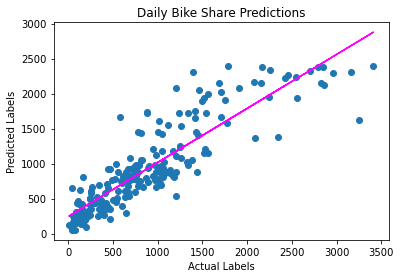

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Train the model
model = RandomForestRegressor().fit(X_train, y_train)
print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

For good measure, let's also try a *boosting* ensemble algorithm. We'll use a Gradient Boosting estimator, which like a Random Forest algorithm builds multiple trees, but instead of building them all independently and taking the average result, each tree is built on the outputs of the previous one in an attempt to incrementally reduce the *loss* (error) in the model.

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 

MSE: 104088.1617828085
RMSE: 322.6269700177102
R2: 0.7959416917769964


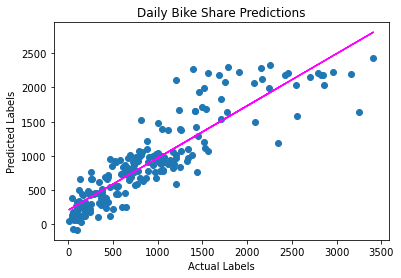

In [41]:
# Train the model
from sklearn.ensemble import GradientBoostingRegressor

# Fit a lasso model on the training set
model = GradientBoostingRegressor().fit(X_train, y_train)
print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

## Optimize Hyperparameters

Take a look at the **GradientBoostingRegressor** estimator definition in the output above, and note that it, like the other estimators we tried previously, includes a large number of parameters that control the way the model is trained. In machine learning, the term *parameters* refers to values that can be determined from data; values that you specify to affect the behavior of a training algorithm are more correctly referred to as *hyperparameters*.

The specific hyperparameters for an estimator vary based on the algorithm that the estimator encapsulates. In the case of the **GradientBoostingRegressor** estimator, the algorithm is an ensemble that combines multiple decision trees to create an overall predictive model. You can learn about the hyperparameters for this estimator in the [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html).

We won't go into the details of each hyperparameter here, but they work together to affect the way the algorithm trains a model. In many cases, the default values provided by Scikit-Learn will work well; but there may be some advantage in modifying hyperparameters to get better predictive performance or reduce training time.

So how do you know what hyperparameter values you should use? Well, in the absence of a deep understanding of how the underlying algorithm works, you'll need to experiment. Fortunately, SciKit-Learn provides a way to *tune* hyperparameters by trying multiple combinations and finding the best result for a given performance metric.

Let's try using a *grid search* approach to try combinations from a grid of possible values for the **learning_rate** and **n_estimators** hyperparameters of the **GradientBoostingRegressor** estimator.

Best parameter combination: {'learning_rate': 0.1, 'n_estimators': 100} 

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 

MSE: 104212.58519100046
RMSE: 322.8197410181113
R2: 0.7956977674945023


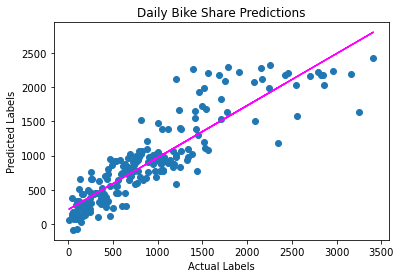

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Try these hyperparameter values
params = {
 'learning_rate': [0.1, 0.5, 1.0],
 'n_estimators' : [50, 100, 150]
 }

# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, params, scoring=score, cv=3, return_train_score=True)
gridsearch.fit(X_train, y_train)
print("Best parameter combination:", gridsearch.best_params_, "\n")

# Get the best model
model=gridsearch.best_estimator_
print(model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

> **Note**: The use of random values in the Gradient Boosting algorithm results in slightly different metrics each time. In this case, the best model produced by hyperparameter tuning is unlikely to be significantly better than one trained with the default hyperparameter values; but it's still useful to know about the hyperparameter tuning technique!

## Preprocess the Data

We trained a model with data that was loaded straight from a source file, with only moderately successful results.

In practice, it's common to perform some preprocessing of the data to make it easier for the algorithm to fit a model to it. There's a huge range of preprocessing transformations you can perform to get your data ready for modeling, but we'll limit ourselves to a few common techniques:

### Scaling numeric features

Normalizing numeric features so they're on the same scale prevents features with large values from producing coefficients that disproportionately affect the predictions. For example, suppose your data includes the following numeric features:

| A |  B  |  C  |
| - | --- | --- |
| 3 | 480 | 65  |
    
Normalizing these features to the same scale may result in the following values (assuming A contains values from 0 to 10, B contains values from 0 to 1000, and C contains values from 0 to 100):

|  A  |  B  |  C  |
| --  | --- | --- |
| 0.3 | 0.48| 0.65|

There are multiple ways you can scale numeric data, such as calculating the minimum and maximum values for each column and assigning a proportional value between 0 and 1, or by using the mean and standard deviation of a normally distributed variable to maintain the same *spread* of values on a different scale.

### Encoding categorical variables

Machine learning models work best with numeric features rather than text values, so you generally need to convert categorical features into numeric representations.  For example, suppose your data includes the following categorical feature. 

| Size |
| ---- |
|  S   |
|  M   |
|  L   |

You can apply *ordinal encoding* to substitute a unique integer value for each category, like this:

| Size |
| ---- |
|  0   |
|  1   |
|  2   |

Another common technique is to use *one hot encoding* to create individual binary (0 or 1) features for each possible category value. For example, you could use one-hot encoding to translate the possible categories into binary columns like this:

|  Size_S  |  Size_M  |  Size_L  |
| -------  | -------- | -------- |
|    1     |     0    |    0     |
|    0     |     1    |    0     |
|    0     |     0    |    1     |

To apply these preprocessing transformations to the bike rental, we'll make use of a Scikit-Learn feature named *pipelines*. These enable us to define a set of preprocessing steps that end with an algorithm. You can then fit the entire pipeline to the data, so that the model encapsulates all of the preprocessing steps as well as the regression algorithm. This is useful, because when we want to use the model to predict values from new data, we need to apply the same transformations (based on the same statistical distributions and category encodings used with the training data).

>**Note**: The term *pipeline* is used extensively in machine learning, often to mean very different things! In this context, we're using it to refer to pipeline objects in Scikit-Learn, but you may see it used elsewhere to mean something else.

In [43]:
# Train the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
import numpy as np

# Define preprocessing for numeric columns (scale them)
numeric_features = [6,7,8,9]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

In [44]:
# Define preprocessing for categorical features (encode them)
categorical_features = [0,1,2,3,4,5]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [45]:
# Combine preprocessing steps - attach the created transformers to the columns to be transformed
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [46]:
# Train the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
import numpy as np

# Define preprocessing for numeric columns (scale them)
numeric_features = [6,7,8,9]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
categorical_features = [0,1,2,3,4,5]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor())])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  [6, 7, 8, 9]),
                                                 ('cat',
                                                  Pipeline(memory=N

OK, the model is trained, including the preprocessing steps. Let's see how it performs with the validation data.

MSE: 105033.32743887613
RMSE: 324.08845619502733
R2: 0.7940887538303152


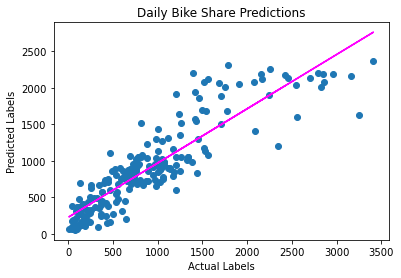

In [47]:
# Get predictions
predictions = model.predict(X_test)

# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

The pipeline is composed of the transformations and the algorithm used to train the model. To try an alternative algorithm you can just change that step to a different kind of estimator.

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  [6, 7, 8, 9]),
                                                 ('cat',
                                                  Pipeline(memory=N

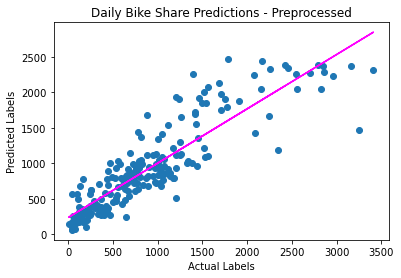

In [48]:
# Use a different estimator in the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor())])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model, "\n")

# Get predictions
predictions = model.predict(X_test)

# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions - Preprocessed')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

We've now seen a number of common techniques used to train predictive models for regression. In a real project, you'd likely try a few more algorithms, hyperparameters, and preprocessing transformations; but by now you should have got the general idea. Let's explore how you can use the trained model with new data.

### Use the Trained Model

First, let's save the model.

In [49]:
import joblib

# Save the model as a pickle file
filename = './models/bike-share.pkl'
joblib.dump(model, filename)

['./models/bike-share.pkl']

Now, we can load it whenever we need it, and use it to predict labels for new data. This is often called *scoring* or *inferencing*.

In [50]:
# Load the model from the file
loaded_model = joblib.load(filename)

# Create a numpy array containing a new observation (for example tomorrow's seasonal and weather forecast information)
X_new = np.array([[1,1,0,3,1,1,0.226957,0.22927,0.436957,0.1869]]).astype('float64')
print ('New sample: {}'.format(list(X_new[0])))

# Use the model to predict tomorrow's rentals
result = loaded_model.predict(X_new)
print('Prediction: {:.0f} rentals'.format(np.round(result[0])))

New sample: [1.0, 1.0, 0.0, 3.0, 1.0, 1.0, 0.226957, 0.22927, 0.436957, 0.1869]
Prediction: 106 rentals


The model's **predict** method accepts an array of observations, so you can use it to generate multiple predictions as a batch. For example, suppose you have a weather forecast for the next five days; you could use the model to predict bike rentals for each day based on the expected weather conditions.

In [51]:
# An array of features based on five-day weather forecast
X_new = np.array([[0,1,1,0,0,1,0.344167,0.363625,0.805833,0.160446],
                  [0,1,0,1,0,1,0.363478,0.353739,0.696087,0.248539],
                  [0,1,0,2,0,1,0.196364,0.189405,0.437273,0.248309],
                  [0,1,0,3,0,1,0.2,0.212122,0.590435,0.160296],
                  [0,1,0,4,0,1,0.226957,0.22927,0.436957,0.1869]])

# Use the model to predict rentals
results = loaded_model.predict(X_new)
print('5-day rental predictions:')
for prediction in results:
    print(np.round(prediction))

5-day rental predictions:
582.0
735.0
247.0
222.0
300.0


## Further Reading

To learn more about Scikit-Learn, see the [Scikit-Learn documentation](https://scikit-learn.org/stable/user_guide.html).

## Challenge: Predict Real Estate Prices

Think you're ready to create your own regression model? Try the challenge of predicting real estate property prices in the [/challenges/02 - Real Estate Regression Challenge.ipynb](./challenges/02%20-%20Real%20Estate%20Regression%20Challenge.ipynb) notebook!

> **Note**: The time to complete this optional challenge is not included in the estimated time for this exercise - you can spend as little or as much time on it as you like!

##  Find baseline model using a variety of algorithms or Dummy algorithm

In [52]:
# Train the model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor


def evaluateBaseModel(reg_algos, X_train, X_test, y_train, y_test):
    """
        reg_algos  - a list of regression algortithms sent in for prediction and evaluation of the model 

    """
    for algo in reg_algos:
        model = algo.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        chart = compareTrueAndPredictedLabels(y_test, y_pred, str(algo).split(','))
        display(chart.configure_title(fontSize=8))
    


    

In [53]:
reg_algos = []

reg_algos.append(DummyRegressor())
reg_algos.append(LinearRegression())
reg_algos.append(DecisionTreeRegressor())
reg_algos.append(GradientBoostingRegressor())

evaluateBaseModel(reg_algos, X_train, X_test, y_train, y_test)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

In [54]:
X_train[0]

array([2.      , 6.      , 0.      , 5.      , 1.      , 1.      ,
       0.649167, 0.597862, 0.467917, 0.175383])

In [81]:
def evaluatePipelineModel(pipeline, X_train, X_test, y_train, y_test, algo):
    """
        reg_algos  - a list of tuples of regression algortithms sent in for prediction and evaluation of the model 

    """
    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    chart = compareTrueAndPredictedLabels(y_test, y_pred, str(algo).split(','))

    display(chart.configure_title(fontSize=8))
    return model

In [82]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline



def createPipelineAndEvaluate(df, not_features_cols, features_cols,):
    """"
        This function identifies the numeric (continuous values) columns and discrete value columns 
        It then transofrms teh columns using StatndardScaler and OneHotEncoding respectively

        Then a pipeline is created using make_pipeline to send the transofrmed dataset to a ML algorithm 
    """

    numeric_columns = df.select_dtypes('float').columns.values
    categorical_columns = df.select_dtypes('int').columns.values
    # remove the columns that are not features from the above lists
    categorical_columns = np.setdiff1d(categorical_columns,  np.array(not_features_cols))
    numeric_columns = np.setdiff1d(numeric_columns,  np.array(not_features_cols))

    # These are the columns of our training array
    X_cols = features_cols

    # find the numerical indexes of the column in the ndarray corresponding to floating columns that have to be scaled and the categorical columns that have to be one hot encoded
    num_col_indexes = [i for num_col in numeric_columns for i,x in enumerate(X_cols) if x == num_col]
    cat_col_indexes = [i for num_col in categorical_columns for i,x in enumerate(X_cols) if x == num_col]

    #define the scaling for the numeric columns
    # specify the columns that will go through each transformation
    # Combine preprocessing steps
    preprocessor = make_column_transformer(
                (StandardScaler(), numeric_features),
                (OneHotEncoder(handle_unknown='ignore'), categorical_features))


    algo = GradientBoostingRegressor()
    # Create preprocessing and training pipeline
    pipeline = make_pipeline( preprocessor, algo)


    # fit the pipeline to train an algorithm to create a  model on the training set 
    model = evaluatePipelineModel(pipeline, X_train, X_test, y_train, y_test, algo)
    return model




In [83]:

not_features_cols = ['instant', 'dteday', 'yr', 'day', 'rentals']
features_cols = ['season','mnth', 'holiday','weekday','workingday','weathersit','temp', 'atemp', 'hum', 'windspeed']

model = createPipelineAndEvaluate(bike_data, not_features_cols, features_cols,)

alt.LayerChart(...)

In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score
# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Try these hyperparameter values
params = {
 'learning_rate': [0.1, 0.5, 1.0],
 'n_estimators' : [50, 100, 150]
 }
CV_FOLDS = 3

def compareAlgosWithGridSearch(list_algos, algo_params, algo_scoring, CV_FOLDS )
    """
            This function will run GridSearchCV on the algorith list passed in 
            The algo_params is a list of dictionaries of params pertaining to each algorithm
    """


# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, params, scoring=score, cv=CV_FOLDS, return_train_score=True)
gridsearch.fit(X_train, y_train)
print("Best parameter combination:", gridsearch.best_params_, "\n")

# Get the best model
model=gridsearch.best_estimator_
print(model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('standardscaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  [6, 7, 8, 9]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                h